# Notebook to generate g - alpha*r image to reveal the source

Subtract away the lens galaxy (using the z-band image) from the g-band and r-band images, to reveal the lensed source. All of the objects in the image have the same morphology, but different brightnesses for the various components. Each image has been convolved with a circular 2D gaussian PSF kernel, and then noise added, to simulate an observation. The gaussian PSF is a slightly different size in each band, with the size getting smaller as you go redder (as is typical in real data i.e. the “seeing” is worse as you go bluer). To optimally subtract the z-band image from each of the bluer images, you’ll have to experimentally solve for difference in seeing (i.e. you’ll have to convolve the z-band image with some kind of kernel (I suggest starting with a 2D gaussian) to blur it out to match to each of the bluer frames) and then solve for the flux scaling that removes the lens. I.e. the flux scaling you’re looking for is equivalent to the alpha in a “g-alpha*i” image as we saw in the paper on Monday (though in this case r-z or g-z not g-i :)). My suggestion for how to attack this is: use the star image to find the blurring kernel you need. Once established, fix that, and find the scaling.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.visualization import LogStretch
from astropy.convolution import Gaussian2DKernel
from astropy.convolution import convolve
from scipy import optimize
import os

plt.style.use('classic')
plt.rc('font', family='Times New Roman')

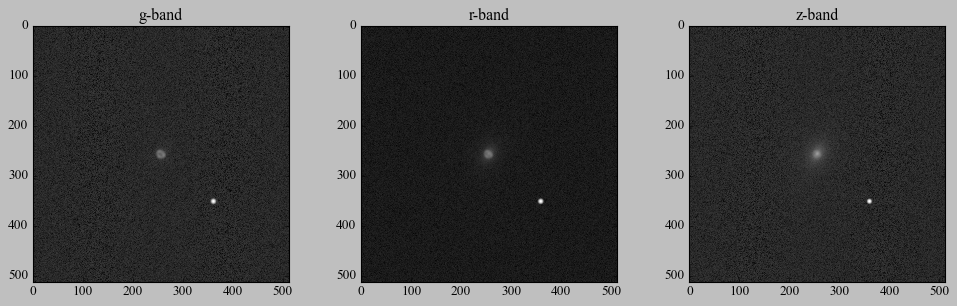

In [2]:
# view the images
gband = fits.getdata('/Users/panyue/COOL_LAMPS/team1a/filter_subtraction/g.fits')
rband = fits.getdata('/Users/panyue/COOL_LAMPS/team1a/filter_subtraction/r.fits')
zband = fits.getdata('/Users/panyue/COOL_LAMPS/team1a/filter_subtraction/z.fits')
gband = np.array(gband)
rband = np.array(rband)
zband = np.array(zband)
grzband = [gband, rband, zband]
grz = ['g-band', 'r-band', 'z-band']
norm = ImageNormalize(stretch = LogStretch())

f, axarr = plt.subplots(1, 3, figsize=(15,4))
for i, image in enumerate(grzband):
    axarr[i].imshow(image, norm = norm, cmap = 'gray')
    axarr[i].set_title(grz[i])
    

In [3]:
# select a region around the star
brightest_pxl = np.max(zband)
pos = np.where(zband == brightest_pxl)
xpos, ypos = pos[0], pos[1]
# select a square region to contain this star (length=30)
size = 3
# in what follows, we will first use the cropped image that contains the star to find the PSF
# then we will use the PSF to find the rescaling factor
star_cropped_z = zband[int(xpos)-size:int(xpos)+size][:,int(ypos)-size:int(ypos)+size]
star_cropped_g = gband[int(xpos)-size:int(xpos)+size][:,int(ypos)-size:int(ypos)+size]
star_cropped_r = rband[int(xpos)-size:int(xpos)+size][:,int(ypos)-size:int(ypos)+size]

In [4]:
def convolve_rescale_star_gz(x):
    """
    Convolve the original image with a Gaussian kernel, then rescale it
    ----------
    Input:
        x: 1d list of length 2
           x[0]: the width of Gaussian kernel
           x[1]: the rescaling factor
    ----------
    Output:
        diffsum: float
                 the sum of the the residual pixel values between convolved, rescaled z-band image
                 and original g-band image
    """
    # first smooth the image
    img = star_cropped_z
    # make the sure kernel has a positive size:
    if x[0] > 0:
        kernel = Gaussian2DKernel(x_stddev=x[0])
    else:
        kernel = Gaussian2DKernel(x_stddev=2)
    z_conv = convolve(img, kernel)
    # then rescale it
    z_final = z_conv * x[1]
    # finally subtract it from g-band image
    diff = (z_final - star_cropped_g)**2
    diffsum = np.sqrt(np.sum(diff))
    
    return diffsum

In [5]:
def convolve_rescale_star_rz(x):
    """
    Convolve the original image with a Gaussian kernel, then rescale it
    ----------
    Input:
        x: 1d list of length 2
           x[0]: the width of Gaussian kernel
           x[1]: the rescaling factor
    ----------
    Output:
        diffsum: float
                 the sum of the the residual pixel values between convolved, rescaled z-band image
                 and original g-band image
    """
    # first smooth the image
    img = star_cropped_z
    # make the sure kernel has a positive size:
    if x[0] > 0:
        kernel = Gaussian2DKernel(x_stddev=x[0])
    else:
        kernel = Gaussian2DKernel(x_stddev=2)
    z_conv = convolve(img, kernel)
    # then rescale it
    z_final = z_conv * x[1]
    # finally subtract it from g-band image
    diff = (z_final - star_cropped_r)**2
    diffsum = np.sqrt(np.sum(diff))
    
    return diffsum

In [6]:
# use Nelder-Mead to find the minimization; x0 is an initial guess: (width, scaling factor)
res = optimize.minimize(convolve_rescale_star_gz, x0=[5, 0.3], method='Nelder-Mead')
width_gz, f_rescale_gz = res.x[0], res.x[1]
print(width_gz, f_rescale_gz)

0.9355205971135312 1.0599853879224297


In [7]:
# use Nelder-Mead to find the minimization; x0 is an initial guess: (width, scaling factor)
res = optimize.minimize(convolve_rescale_star_rz, x0=[5, 0.3], method='Nelder-Mead')
width_rz, f_rescale_rz = res.x[0], res.x[1]
print(width_rz, f_rescale_rz)

0.6356148749989781 1.0244587867497352


In [8]:
# select a region that contains the central lens galaxy
length = len(zband)
xpos, ypos = length/2, length/2
# select a square region to contain this lens galaxy
size = 50
lens_cropped_z = zband[int(xpos)-size:int(xpos)+size][:,int(ypos)-size:int(ypos)+size]
lens_cropped_g = gband[int(xpos)-size:int(xpos)+size][:,int(ypos)-size:int(ypos)+size]
lens_cropped_r = rband[int(xpos)-size:int(xpos)+size][:,int(ypos)-size:int(ypos)+size]

In [9]:
def convolve_rescale_lens_gz(x):
    """
    Similar to the previous function, but instead of using the portion of the image that contains the star,
    we use the central portion that contains the lens
    We also use the width of the Gaussian kernel derived in the previous step
    We only need to solve for the rescaling factor here; x is one-dimensional
    """
    # first smooth the image
    img = lens_cropped_z
    # use the kernel whose width we derived earlier
    kernel = Gaussian2DKernel(x_stddev=width_gz)
    z_conv = convolve(img, kernel)
    # then rescale it
    z_final = z_conv * x
    # finally subtract it from g-band image
    diff = (z_final - lens_cropped_g)**2
    diffsum = np.sqrt(np.sum(diff))
    
    return diffsum

In [10]:
def convolve_rescale_lens_rz(x):
    """
    Similar to the previous function, but instead of using the portion of the image that contains the star,
    we use the central portion that contains the lens
    We also use the width of the Gaussian kernel derived in the previous step
    We only need to solve for the rescaling factor here; x is one-dimensional
    """
    # first smooth the image
    img = lens_cropped_z
    # use the kernel whose width we derived earlier
    kernel = Gaussian2DKernel(x_stddev=width_rz)
    z_conv = convolve(img, kernel)
    # then rescale it
    z_final = z_conv * x
    # finally subtract it from g-band image
    diff = (z_final - lens_cropped_r)**2
    diffsum = np.sqrt(np.sum(diff))
    
    return diffsum

In [11]:
# use Nelder-Mead to find the minimization; x0 is an initial guess: scaling factor
res = optimize.minimize(convolve_rescale_lens_gz, x0=4, method='Nelder-Mead')
f_rescale_gz = res.x[0]
# and this will be the final answer!
print(width_gz, f_rescale_gz)

0.9355205971135312 0.5710937499999971


In [12]:
# use Nelder-Mead to find the minimization; x0 is an initial guess: scaling factor
res = optimize.minimize(convolve_rescale_lens_rz, x0=4, method='Nelder-Mead')
f_rescale_rz = res.x[0]
# and this will be the final answer!
print(width_rz, f_rescale_rz)

0.6356148749989781 0.5254882812499969


In [14]:
# convert sigma to PSF: PSF = 2.355 * sigma
psf_gz = width_gz * 2.355
print('g-z: PSF = {:2f}; scaling factor = {:2f}'.format(psf_gz, f_rescale_gz))

g-z: PSF = 2.203151; scaling factor = 0.571094


In [15]:
# convert sigma to PSF: PSF = 2.355 * sigma
psf_rz = width_rz * 2.355
print('r-z: PSF = {:2f}; scaling factor = {:2f}'.format(psf_rz, f_rescale_rz))

r-z: PSF = 1.496873; scaling factor = 0.525488


In [16]:
# use this value of PSF and scaling factor (gz)
kernel_gz = Gaussian2DKernel(x_stddev=width_gz)
z_conv = convolve(zband, kernel_gz)
zband_final = z_conv * f_rescale_gz
gz = gband - zband_final

In [17]:
# use this value of PSF and scaling factor (rz)
kernel_rz = Gaussian2DKernel(x_stddev=width_rz)
z_conv = convolve(zband, kernel_rz)
zband_final = z_conv * f_rescale_rz
rz = rband - zband_final

Text(0.5, 1.0, 'r - $\\alpha $ * z')

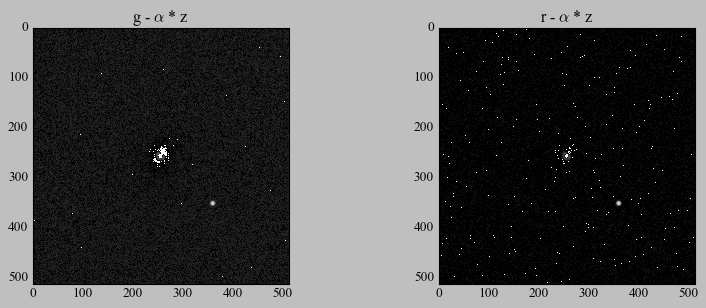

In [19]:
# make need to find a better way to show this....
f, axarr = plt.subplots(1, 2, figsize=(12,4))

axarr[0].imshow(gz, norm = norm, cmap = 'gray')
axarr[0].set_title('g - $\\alpha $ * z')

axarr[1].imshow(rz, norm = norm, cmap = 'gray')
axarr[1].set_title('r - $\\alpha $ * z')

In [21]:
# convert the image to a fits file
hdu = fits.PrimaryHDU(gz)
hdul = fits.HDUList([hdu])
if os.path.exists('gz.fits'): # if the file already exists, overwrite it
    os.remove('gz.fits')
    hdul.writeto('gz.fits')
else:
    hdul.writeto('gz.fits')

In [22]:
hdu = fits.PrimaryHDU(rz)
hdul = fits.HDUList([hdu])
if os.path.exists('rz.fits'):
    os.remove('rz.fits')
    hdul.writeto('rz.fits')
else:
    hdul.writeto('rz.fits')